**Import Libraries and Load Data**

In [50]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    recall_score,
    precision_score,
)
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [51]:
X_test = pd.read_csv('X_test.csv').reset_index(drop=True).drop('Unnamed: 0', axis=1)
y_test = pd.read_csv('y_test.csv')
X_train = pd.read_csv('X_train.csv').drop('Unnamed: 0', axis=1).reset_index(drop=True)
y_train = pd.read_csv('y_train.csv')
y_train['label'] = y_train['label'].replace({False: 0, True: 1})
y_test['label'] = y_test['label'].replace({False: 0, True: 1})


In [52]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train['label'])
y_pred  = model.predict(X_test)

**Confusion matrix**

In [53]:
acc = accuracy_score(y_test['label'], y_pred)
sens = recall_score(y_test['label'], y_pred)
prec = precision_score(y_test['label'], y_pred)

print("Accuracy:", acc)
print("Sensitivity:", sens)
print("Precision:", prec)

Accuracy: 0.8016528925619835
Sensitivity: 0.792
Precision: 0.8181818181818182


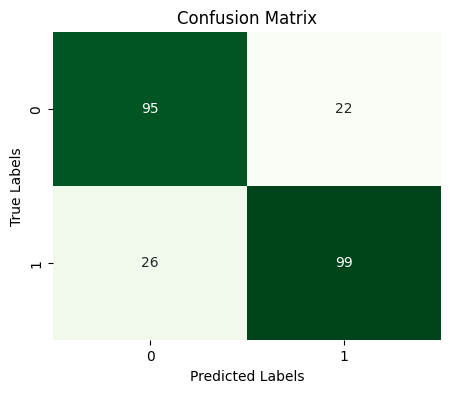

In [54]:
cm = confusion_matrix(y_test['label'], y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap="Greens", fmt="d", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

**Feature Importance**

In [55]:
print("important features")
importances = model.feature_importances_
columns_enumeration = [(column, i) for i, column in enumerate(X_train.columns)]
columns_enumeration.sort()
for column, i in columns_enumeration:
    print(f"{column}:{round(importances[i], ndigits=3)} - Index: {i}", end="\n")

important features
d0:0.07 - Index: 2
d1:0.071 - Index: 6
d2:0.062 - Index: 10
d3:0.069 - Index: 14
reaction0:0.007 - Index: 1
reaction1:0.007 - Index: 5
reaction2:0.006 - Index: 9
reaction3:0.008 - Index: 13
reaction_ref:0.006 - Index: 0
same_profile0:0.038 - Index: 4
same_profile1:0.055 - Index: 8
same_profile2:0.043 - Index: 12
same_profile3:0.032 - Index: 16
timegap0:0.102 - Index: 3
timegap1:0.096 - Index: 7
timegap2:0.132 - Index: 11
timegap3:0.196 - Index: 15


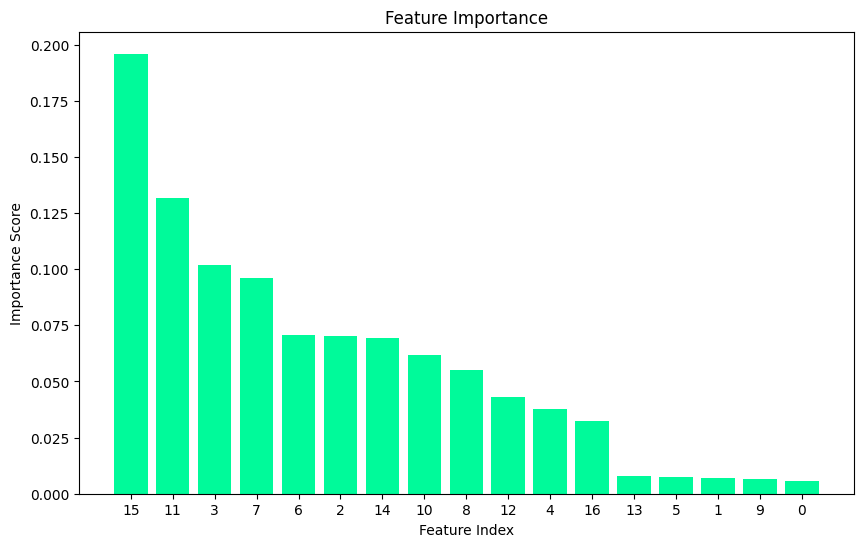

In [56]:
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices], align="center", color = '#00FA9A')
plt.xticks(range(X_train.shape[1]),indices) #[columns_enumeration[i] for i in indices])
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.show()

**Permutation Importance**

Permutation Importance evaluates the drop in model performance when the values of a feature are randomly shuffled. A larger drop indicates higher importance.

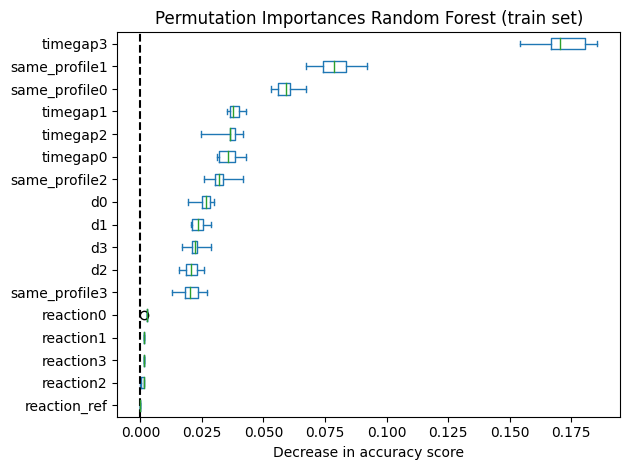

In [57]:
perm_importance_rf = permutation_importance(model, X_train, y_train['label'], n_repeats=10, random_state=42)
sorted_importances_idx = perm_importance_rf.importances_mean.argsort()
importances = pd.DataFrame(
    perm_importance_rf.importances[sorted_importances_idx].T,
    columns=X_test.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances Random Forest (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

Tree's Feature Importance from Mean Decrease in Impurity (MDI): the impurity-based feature importance ranks the numerical features to be the most important features.

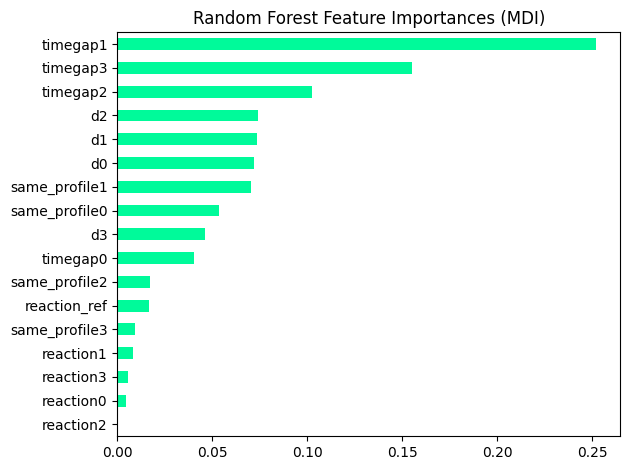

In [58]:
feature_names = X_train.columns

mdi_importances = pd.Series(
    model[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)
ax = mdi_importances.plot.barh(color = '#00FA9A')
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

**Test Set Analysis**

Compare frequency of *true* and *predicted* changes in conversations detected by RandomForest on the test set.

In [59]:
X_test = pd.read_csv('X_test_w_group.csv')
test = pd.merge(X_test, y_test, on = 'Unnamed: 0', how = 'inner')
test['y_pred'] = y_pred
df = test.rename(columns = {'label': 'y_test'})

In [60]:
print(len(X_test))

242


In [61]:
grouped = df.groupby('group')
true_drifts, predicted_drifts, diff = [], [], []
true_no_change, predicted_no_change, diff_no_change = [], [], []
group_counts = []

for name, group in grouped:
  true = (group['y_test'] == 0).sum()
  pred = (group['y_pred'] == 0).sum()
  d = true - pred

  true_no = (group['y_test'] == 1).sum()
  pred_no = (group['y_pred'] == 1).sum()
  d_no = true_no - pred_no

  count = len(group)

  true_drifts.append((name, true))
  true_no_change.append((name, true_no))

  predicted_drifts.append((name, pred))
  predicted_no_change.append((name, pred_no))

  diff.append((name, d))
  diff_no_change.append((name, d_no))

  group_counts.append((name, count))

Distribution of Test Set among Groups

In [62]:
group_counts

[('https://t.me/PoliGruppo', 13),
 ('https://t.me/joinchat/FNGD_0n6IpIbjfJBAZsuoA', 43),
 ('https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ', 63),
 ('https://t.me/joinchat/RL4pXSkXipyuKDmd', 65),
 ('https://t.me/joinchat/aiAC6RgOjBRkYjhk', 18),
 ('https://t.me/joinchat/qyxbq_vZ5f4xYzg0', 13),
 ('https://t.me/joinchat/rLRXuuItcHtkMTVk', 27)]

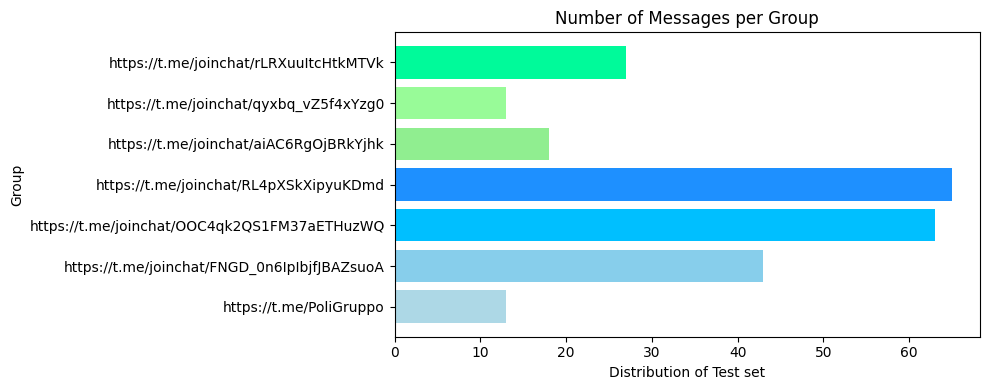

In [63]:
group_counts_values = [count for _, count in group_counts]
group_names = [group_name for group_name, _ in group_counts]

index = np.arange(len(group_names))

plt.figure(figsize=(10, 4))
colors = ['#ADD8E6', '#87CEEB', '#00BFFF', '#1E90FF', '#90EE90', '#98FB98', '#00FA9A']
plt.barh(index, group_counts_values, color=colors)

plt.xlabel('Distribution of Test set')
plt.ylabel('Group')
plt.title('Number of Messages per Group')
plt.yticks(index, group_names)

plt.tight_layout()
plt.show()

In [64]:
print('True Change in conversation:\n', true_drifts)
print('Predicted Change in conversation:\n', predicted_drifts)

True Change in conversation:
 [('https://t.me/PoliGruppo', 0), ('https://t.me/joinchat/FNGD_0n6IpIbjfJBAZsuoA', 23), ('https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ', 55), ('https://t.me/joinchat/RL4pXSkXipyuKDmd', 47), ('https://t.me/joinchat/aiAC6RgOjBRkYjhk', 0), ('https://t.me/joinchat/qyxbq_vZ5f4xYzg0', 0), ('https://t.me/joinchat/rLRXuuItcHtkMTVk', 0)]
Predicted Change in conversation:
 [('https://t.me/PoliGruppo', 3), ('https://t.me/joinchat/FNGD_0n6IpIbjfJBAZsuoA', 27), ('https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ', 42), ('https://t.me/joinchat/RL4pXSkXipyuKDmd', 41), ('https://t.me/joinchat/aiAC6RgOjBRkYjhk', 0), ('https://t.me/joinchat/qyxbq_vZ5f4xYzg0', 5), ('https://t.me/joinchat/rLRXuuItcHtkMTVk', 3)]


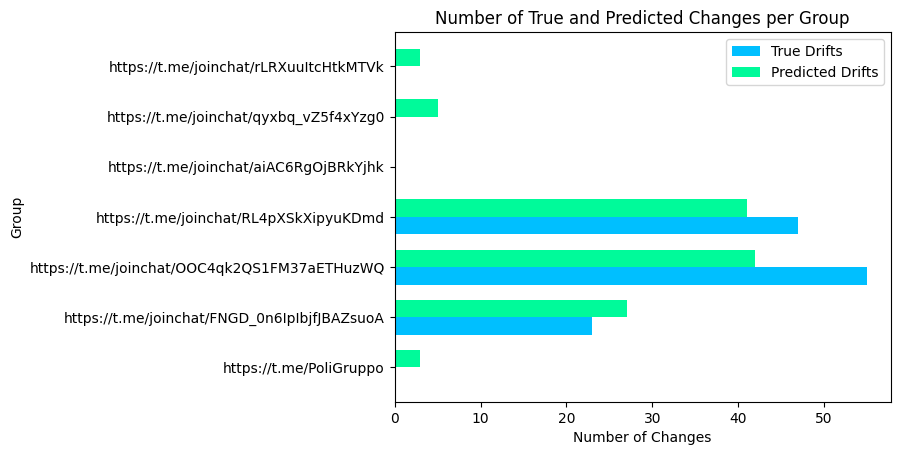

In [65]:
true_counts = [count for _, count in true_drifts]
predicted_counts = [count for _, count in predicted_drifts]
group_names = [group_name for group_name, _ in true_drifts]

bar_width = 0.35
index = np.arange(len(group_names))
plt.barh(index, true_counts, bar_width, label='True Drifts', color='#00BFFF')
plt.barh(index + bar_width, predicted_counts, bar_width, label='Predicted Drifts', color='#00FA9A')

plt.xlabel('Number of Changes')
plt.ylabel('Group')
plt.title('Number of True and Predicted Changes per Group')
plt.yticks(index + bar_width / 2, group_names)
plt.legend()
plt.show()


Analysis of the difference of *true* and *predicted* conversation changes detected on the test set.

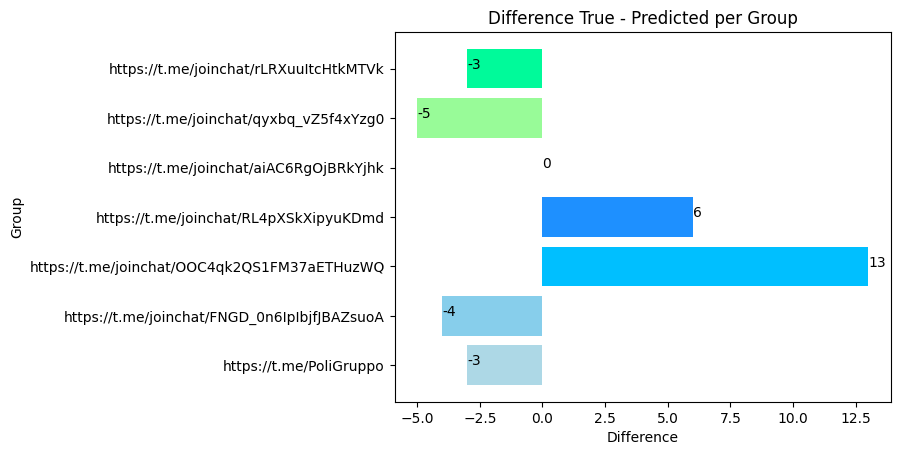

In [66]:
d = [difference for _,difference in diff]
g = [group for group,_ in diff]

plt.barh(g, d, color = colors)

plt.xlabel('Difference')
plt.ylabel('Group')
plt.title('Difference True - Predicted per Group')
for i, value in enumerate(d):
    plt.text(value, i, str(value))
plt.show()

Analysis of *False* and *True* negative results

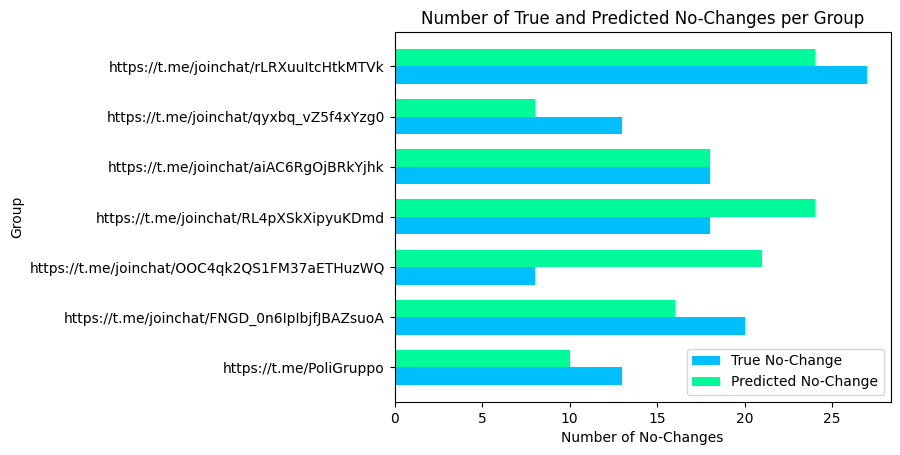

In [67]:
true_counts = [count for _, count in true_no_change]
predicted_counts = [count for _, count in predicted_no_change]
group_names = [group_name for group_name, _ in true_no_change]

bar_width = 0.35
index = np.arange(len(group_names))
plt.barh(index, true_counts, bar_width, label='True No-Change', color='#00BFFF')
plt.barh(index + bar_width, predicted_counts, bar_width, label='Predicted No-Change', color='#00FA9A')

plt.xlabel('Number of No-Changes')
plt.ylabel('Group')
plt.title('Number of True and Predicted No-Changes per Group')
plt.yticks(index + bar_width / 2, group_names)
plt.legend()
plt.show()

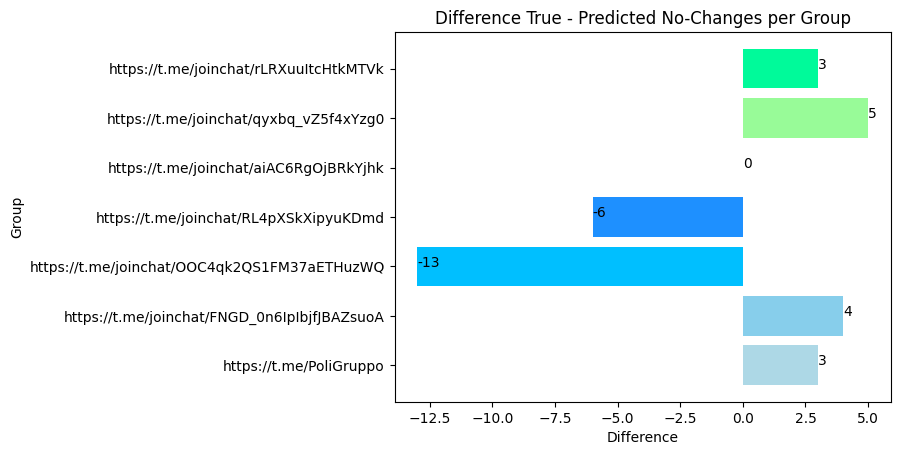

In [68]:
d = [difference for _,difference in diff_no_change]
g = [group for group,_ in diff_no_change]

plt.barh(g, d, color = colors)

plt.xlabel('Difference')
plt.ylabel('Group')
plt.title('Difference True - Predicted No-Changes per Group')
for i, value in enumerate(d):
    plt.text(value, i, str(value))
plt.show()

**Train dataset analysis**

In [69]:
X_train = pd.read_csv('X_train_w_groups.csv')
df_train = pd.merge(X_train, y_train, on = 'Unnamed: 0', how = 'inner')

In [70]:
print(len(X_train))

771


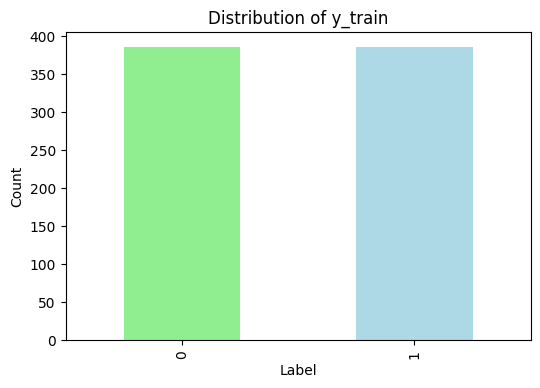

In [71]:
label_counts = df_train['label'].value_counts()

plt.figure(figsize=(6, 4))
label_counts.plot(kind='bar', color=['lightgreen', 'lightblue'])
plt.title('Distribution of y_train')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

Analysis of Message Distribution among the Groups

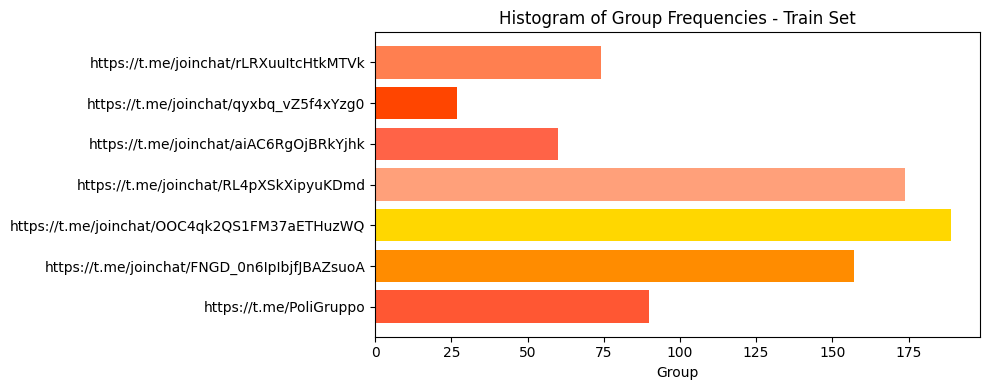

In [72]:
group_counts = df_train.groupby('group').size()
group_names = group_counts.index
frequencies = group_counts.values
plt.figure(figsize=(10, 4))
colors = ['#FF5733', '#FF8C00', '#FFD700', '#FFA07A', '#FF6347', '#FF4500', '#FF7F50']
plt.barh(group_names, frequencies, color=colors)
plt.title('Histogram of Group Frequencies - Train Set')
plt.xlabel('Group')
'''
for i, v in enumerate(frequencies):
    plt.text(v, i, str(v), ha='left', va='center', color='black')
'''
plt.tight_layout()
plt.show()

Dsitribution of change in conversation for each group of the Train Set

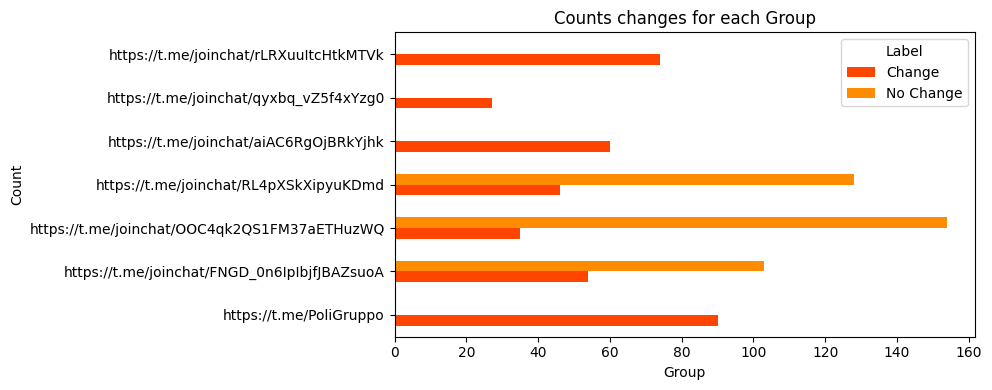

In [74]:
group_label_counts = df_train.groupby('group')['label'].value_counts().unstack()
group_label_counts.plot(kind='barh', figsize=(10, 4), color = ['#FF4500', '#FF8C00'])
plt.title('Counts Changes for each Group')
plt.xlabel('Group')
plt.ylabel('Count')
plt.legend(title='Label', labels=['Change', 'No Change'])
plt.tight_layout()
plt.show()